import libraries

In [18]:
from dtocs import *
from helper import *
from maps import *
import numpy as np
import matplotlib.pyplot as plt
from gdal_interfaces import GDALTileInterface, GDALInterface


# Setup Data folder and GDAL Interface parameter with tiling)
- dirpath: path to the directory where datasets subfolder is stored
- elevation_path: path to folder containing elevation tiles
- landcover_path: path to folder containing landcover tiles

In [19]:
dirpath = "/Users/aakash/Desktop/MTP2/exp/"

elevation_path = dirpath + "elevation"
landcover_path = dirpath + "landcover"
elevation_summary_path = elevation_path + "/elevation_summary.json"
landcover_summary_path = landcover_path + "/landcover_summary.json"

ALWAYS_REBUILD_SUMMARY = False
OPEN_INTERFACES_SIZE = 8

In [20]:
elevation_data_interface = GDALTileInterface(elevation_path, elevation_summary_path, OPEN_INTERFACES_SIZE)
landcover_data_interface = GDALTileInterface(landcover_path, landcover_summary_path, OPEN_INTERFACES_SIZE)

if elevation_data_interface.has_summary_json() and not ALWAYS_REBUILD_SUMMARY:
    print('Re-using existing summary JSON')
    elevation_data_interface.read_summary_json()
else:
    print('Creating summary JSON ...')
    elevation_data_interface.create_summary_json()
    
if landcover_data_interface.has_summary_json() and not ALWAYS_REBUILD_SUMMARY:
    print('Re-using existing summary JSON')
    landcover_data_interface.read_summary_json()
else:
    print('Creating summary JSON ...')
    landcover_data_interface.create_summary_json()

Re-using existing summary JSON
Building spatial index ...
Re-using existing summary JSON
Building spatial index ...


# Bounding box and path dataset filepath
- Add lat1,lon1 and lat2,lon2
- Change resolution
- Add dataset(.tif files) filepath (for GDAL interface (without tiling))

In [24]:
# USA random mountain
# lon1, lat1 = -109.83007049344715, 44.36470033197011
# lon2, lat2 = -109.7513685303535, 44.29673563882564

# India
# lon1, lat1 = 77.28112208857522,32.135432817449384
# lon2, lat2 = 77.62169826045022,31.94918029751246

# Colorado [Whole region]
# lon1, lat1 = -106.72643114729188,38.84785651131714
# lon2, lat2 = -105.95392348402243,39.458493653253676

# Colorado (peak to peak example)
# lat1, lon1 = 38.94374018363843, -106.5759101561709
# lat2, lon2 = 39.04527792014898, -106.38578062842298

# manali (hanuman tibba - manali)
# 31.928,76.854
# 31.694, 77.310

lat1, lon1 = 32.372571, 76.983637
lat2, lon2 = 32.189737, 77.315875
# 32.474, 77.110
# lat1, lon1 = 
# lat2, lon2 = 32.306, 77.745

# # palan - sosan 
# lat1, lon1 = 32.537047, 76.554121
# lat2, lon2 = 31.924304, 77.535921




resolution = 70



# Generate Matrix
- Using GDAL tile interface

In [25]:
elevation_map, landcover_map = getGrayLevelMatrixFromDataSet(lon1, lat1, lon2, lat2, elevation_data_interface, landcover_data_interface, resolution)

start:  32.372571 76.983637
end:  32.189737 77.315875
shape:  291 446


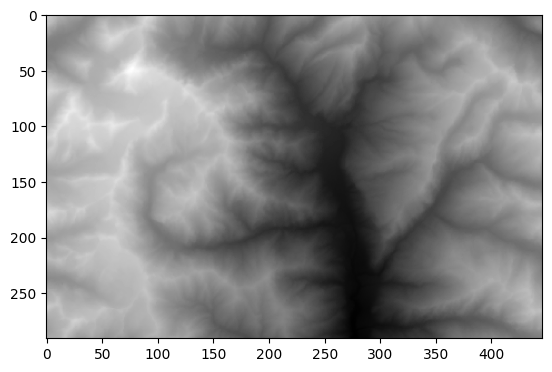

In [26]:
plt.imshow(elevation_map,cmap='gray')
plt.show()

In [27]:
print("Elevation Map Info")
print(f"Gray Map Shape: {elevation_map.shape}")
print(f"Min: {elevation_map.min()}")
print(f"Max: {elevation_map.max()}")

Elevation Map Info
Gray Map Shape: (291, 446)
Min: 1670
Max: 5877


<Axes: >

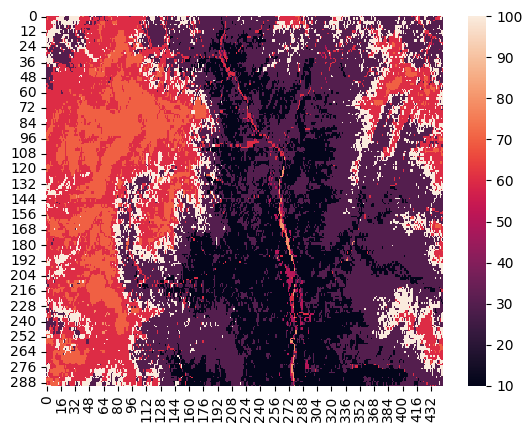

In [28]:
import seaborn as sns
sns.heatmap(landcover_map)

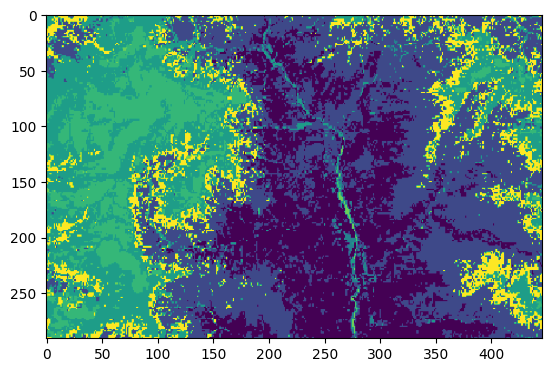

In [29]:
plt.imshow(landcover_map)
plt.show()

Smoothing

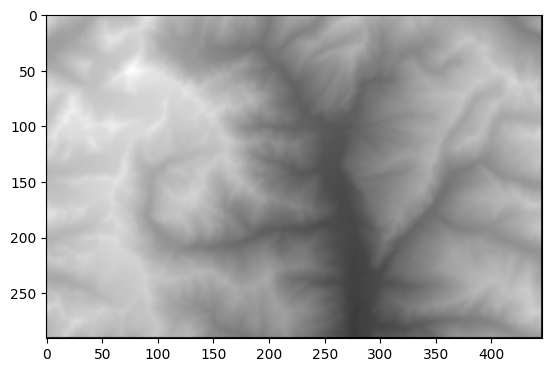

In [30]:
import copy
elevation_smooth = copy.deepcopy(elevation_map)
n, m = elevation_map.shape

for i in range(1, n-1):
            for j in range(1, m-1):
                    elevation_smooth[i][j] = (elevation_map[i-1][j] + elevation_map[i+1][j] + elevation_map[i][j-1] + elevation_map[i-1][j+1])/4

plt.imshow(elevation_smooth, cmap='gray')
plt.show()

Marking peaks

In [31]:
peaks_lat = []
peaks_lon = []
for i in range(1, n-1):
            for j in range(1, m-1):
                    if (elevation_smooth[i][j] > elevation_smooth[i-1][j]) and (elevation_smooth[i][j] > elevation_smooth[i+1][j]) and (elevation_smooth[i][j] > elevation_smooth[i][j-1]) and (elevation_smooth[i][j] > elevation_smooth[i-1][j+1]):
                            peaks_lat.append(i)
                            peaks_lon.append(j)

Show Map

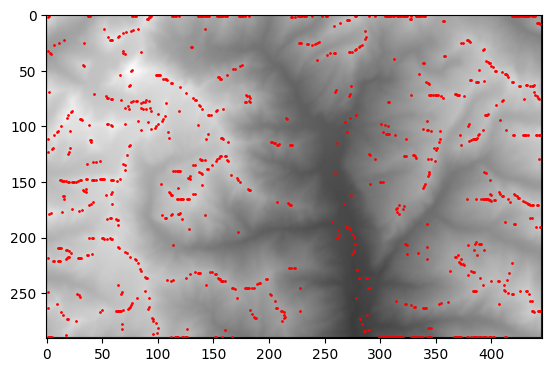

In [32]:
plt.imshow(elevation_smooth, cmap='gray')
plt.scatter(peaks_lon, peaks_lat, color='r', s=1)
plt.show()

Source and Destination

In [10]:
n,m = elevation_map.shape

# USA random
# src_lon,src_lat = -109.81884898177093,44.32480359458633
# des_lon,des_lat = -109.77537406272984,44.30294042398075

# src_lat, src_lon = 38.98065379328955, -106.528761396495
# des_lat, des_lon = 39.02089538747208, -106.42163602957328

# src_lat, src_lon = 32.243724, 77.204016
# src_lat, src_lon = 32.350336, 77.129226
# hanuman tibba
src_lat, src_lon = 32.216951, 77.231191
des_lat, des_lon = 32.341876, 77.040854
# palan
# src_lat, src_lon = 32.369789, 76.766289
# des_lat, des_lon = 32.076790, 77.312516

src_latIdx,src_lonIdx = findIndex(src_lat,src_lon, lat1,lon1, lat2,lon2, resolution)
des_latIdx,des_lonIdx = findIndex(des_lat,des_lon, lat1,lon1, lat2,lon2, resolution)

Dijkstra

In [11]:
# from dijkstra import dijkstraFromSrc, dijkstraFromSrcWithLC, showPathDijkstra
from dijkstra import dijkstraFromSrc, showPathDijkstra

In [12]:
alpha = 0
h_weight = 0.1
slope = 40
# distFromSrc, parentMat  = dijkstraFromSrc(elevation_map, src_latIdx, src_lonIdx, resolution)
distFromSrc, parentMat  = dijkstraFromSrc(elevation_map, landcover_map, src_latIdx, src_lonIdx,alpha,h_weight,resolution,slope)

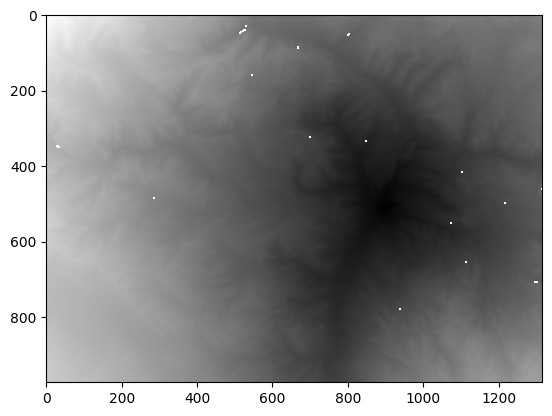

In [13]:
plt.imshow(distFromSrc,cmap='gray')
plt.show()

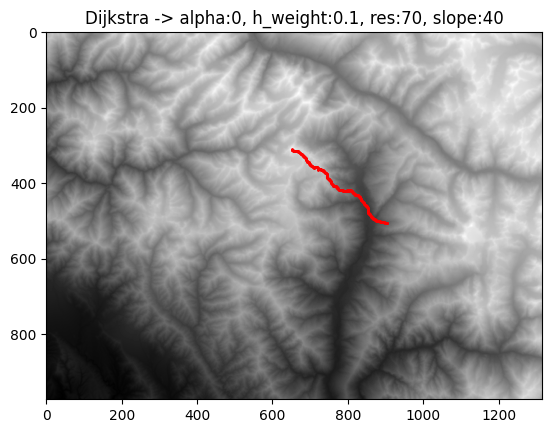

In [14]:
showPathDijkstra(elevation_map, parentMat, src_latIdx, src_lonIdx, des_latIdx, des_lonIdx,alpha,h_weight,resolution,slope)